<a href="https://colab.research.google.com/github/skssushil/Web-mining/blob/master/1_5pricision%2Crecall%26f1_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
import nltk,os,string,copy,pickle,re,math
import numpy as np
import pandas as pd
import warnings
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
import io
with open('CISI.ALL') as f:
    lines = ""
    for l in f.readlines():
        lines += "\n" + l.strip() if l.startswith(".") else " " + l.strip()
    lines = lines.lstrip("\n").split("\n")

In [3]:
doc_set = {}
doc_id = ""
doc_text = ""
for l in lines:
    if l.startswith(".I"):
        doc_id = l.split(" ")[1].strip()
    elif l.startswith(".X"):
        doc_set[doc_id] = doc_text.lstrip(" ")
        doc_id = ""
        doc_text = ""
    else:
        doc_text += l.strip()[3:] + " " # The first 3 characters of a line can be ignored.

In [4]:
dataset = []
for i in doc_set.values():
  dataset.append(i)

In [5]:
N=len(dataset)
print(N)

1460


In [6]:
import io
with open('CISI.QRY') as g:
    qlines = ""
    for m in g.readlines():
        qlines += "\n" + m.strip() if m.startswith(".") else " " + m.strip()
    qlines = qlines.lstrip("\n").split("\n")

In [7]:
qry_set = {}
qry_id = ""
qry_text=""
for m in qlines:
    if m.startswith(".I"):
        qry_id = m.split(" ")[1].strip()
    elif m.startswith(".W"):
        qry_set[qry_id] = m.strip()[3:]
        qry_id = ""
squery=qry_set["100"]

In [8]:
def convert_lower_case(data):
    return np.char.lower(data)

In [9]:
def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

In [10]:
def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

In [11]:
def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

In [12]:
def stemming(data):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

In [14]:
import inflect 
p = inflect.engine()   
# convert number into words 
def convert_number(text): 
  temp_str = text.split() 
  new_string = []  
  for word in temp_str:
    if word.isdigit(): 
      temp = p.number_to_words(word) 
      new_string.append(temp) 
    else:
      new_string.append(word) 
      temp_str = ' '.join(new_string) 
  return temp_str 

In [16]:
def preprocess(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data) #remove comma seperately
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = stemming(data)
    data = remove_punctuation(data)
    data = stemming(data) #needed again as we need to stem the words
    data = remove_punctuation(data) #needed again as num2word is giving few hypens and commas fourty-one
    data = remove_stop_words(data) #needed again as num2word is giving stop words 101 - one hundred and one
    return data

In [17]:
processed_text = []
for i in dataset[:N]:
    processed_text.append(word_tokenize(str(preprocess(convert_number(i)))))

In [18]:
DF = {}
for i in range(N):
    tokens = processed_text[i]
    for w in tokens:
        try:
            DF[w].add(i)
        except:
            DF[w] = {i}
for i in DF:
    DF[i] = len(DF[i])

In [19]:
total_vocab_size = len(DF)
print(total_vocab_size)

7024


In [20]:
total_vocab = [x for x in DF]

In [21]:
print(total_vocab[:20])

['eighteen', 'edit', 'dewey', 'decim', 'classif', 'comaromi', 'present', 'studi', 'histori', 'first', 'ddc', 'publish', '1876', 'eighteenth', '1971', 'futur', 'continu', 'appear', 'need', 'spite']


In [22]:
def doc_freq(word):
    c = 0
    try:
        c = DF[word]
    except:
        pass
    return c

In [23]:
doc = 0
tf_idf = {}
for i in range(N):    
    tokens = processed_text[i]    
    counter = Counter(tokens)
    words_count = len(tokens)    
    for token in np.unique(tokens):        
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = np.log((N+1)/(df+1))        
        tf_idf[doc, token] = tf*idf
    doc += 1

In [24]:
doc = 0
tf_idf = {}
for i in range(N):    
    tokens = processed_text[i]    
    counter = Counter(tokens)
    words_count = len(tokens)    
    for token in np.unique(tokens):        
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = np.log((N+1)/(df+1))        
        tf_idf[doc, token] = tf*idf
    doc += 1

In [25]:
def cosine_sim(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

In [26]:
D = np.zeros((N, total_vocab_size))
for i in tf_idf:
    try:
        ind = total_vocab.index(i[1])
        D[i[0]][ind] = tf_idf[i]
    except:
        pass

In [27]:
def gen_vector(tokens):
    Q = np.zeros((len(total_vocab)))
    counter = Counter(tokens)
    words_count = len(tokens)
    query_weights = {}
    for token in np.unique(tokens):   
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = math.log((N+1)/(df+1))
        try:
            ind = total_vocab.index(token)
            Q[ind] = tf*idf
        except:
            pass
    return Q

In [28]:
def cosine_similarity(query):
    relevent=0
    d_id=[]
    print("Cosine Similarity")
    preprocessed_query = preprocess(query)
    tokens = word_tokenize(str(preprocessed_query))
    print("\nQuery:", query)
    print("")
    #print(tokens)
    d_cosines = []
    query_vector = gen_vector(tokens)
    for d in D:
        d_cosines.append(cosine_sim(query_vector, d))
    for i in d_cosines:
      if i>=.15:
        relevent+=1
        d_id.append(d_cosines.index(i))
    d_id.append(relevent)
    return d_id

    

In [29]:
def ranking(query):
    preprocessed_query = preprocess(query)
    tokens = word_tokenize(str(preprocessed_query))
    d_cosines = []
    query_vector = gen_vector(tokens)
    for d in D:
        d_cosines.append(cosine_sim(query_vector, d))
    out = np.array(d_cosines)
    return out


In [30]:
relevent_doc=cosine_similarity(squery)
no_relevent_doc=relevent_doc[-1]
relevent_doc=relevent_doc[:-1]

Cosine Similarity

Query: This paper notes the benefits accruing from interaction between computerized retrieval systems and micrographic retrieval systems.  It reviews current state of automated micrographic retrieval technology.  The conclusion is that with a combination of advances in communications technology, and sophisticated indexing input from libraries and information scientists, the new generation of automated micrographs devices may constitute the on-line document retrieval systems of the future.



In [31]:
print(no_relevent_doc)
print(relevent_doc)

6
[179, 335, 374, 375, 915, 1135]


In [32]:
ranking_doc=ranking(squery)

precision and recall at each rank position

In [33]:
print(len(ranking_doc))
l=len(ranking_doc)

1460


In [34]:
p=np.zeros((l,4))

In [35]:
print(p.shape)
x=np.array([ranking_doc])
y=np.array(range(0,l))
print(x)

(1460, 4)
[[0.011408   0.03800724 0.00154378 ... 0.05774267 0.01907854 0.06474764]]


In [36]:
p[:,0]=y

In [37]:
print(relevent_doc)
if 37 in relevent_doc:
  print("yes")

[179, 335, 374, 375, 915, 1135]


In [38]:
for i in range(l):
  if p[i][0] in relevent_doc:
    p[i][1]= 1
  else:
    p[i][1]= -1
print(p[37])

[37. -1.  0.  0.]


In [39]:
count=0
cn=0
for i in range(l):
  if p[i][1]==1:
    cn=cn+1
    count=count+1
    p[i][2]= (cn/count)*100
  else:
    count=count+1
    p[i][2]= (cn/count)*100

In [40]:
rc=0
print(no_relevent_doc)
for i in range(l):
  if p[i][1]==1:
    rc=rc+1
    p[i][3]= (rc/no_relevent_doc)*100
  else:
    p[i][3]= (rc/no_relevent_doc)*100

6


In [41]:
pr=[]
for i in relevent_doc:
 pr.append(p[i][2])
avg_pr=sum(pr)/no_relevent_doc
print(" Average Precision ",avg_pr," % ")

 Average Precision  0.68144066341608  % 


In [42]:
#p=p[p[:,2].argsort()[::-1]]

In [43]:
#np.set_printoptions(suppress=True)
print(p)

[[ 0.00000000e+00 -1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00 -1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.00000000e+00 -1.00000000e+00  0.00000000e+00  0.00000000e+00]
 ...
 [ 1.45700000e+03 -1.00000000e+00  4.11522634e-01  1.00000000e+02]
 [ 1.45800000e+03 -1.00000000e+00  4.11240576e-01  1.00000000e+02]
 [ 1.45900000e+03 -1.00000000e+00  4.10958904e-01  1.00000000e+02]]


In [44]:
x=p[:,2]
y=p[:,3]

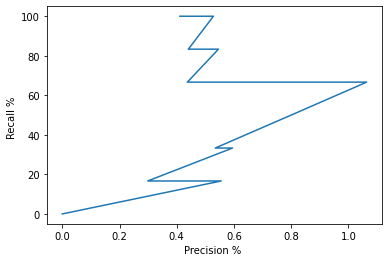

In [47]:
import matplotlib.pyplot as plt
plt.xlabel('Precision % ')
plt.ylabel('Recall % ')
plt.plot(x, y);
plt.show;


F-Measure = (2 * Precision * Recall) / (Precision + Recall)

In [48]:
import math
f_score=[]
for i in range(l):
  f=(2*p[i][2]*p[i][2])/(p[i][2]+p[i][2])
  f_score.append(f)
for i in range(l):
  if math.isnan(f_score[i]):
    f_score[i]=0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [49]:
f_score.sort(reverse = True)
print(f_score[:50])

[1.0638297872340425, 1.0610079575596816, 1.0582010582010581, 1.0554089709762533, 1.0526315789473684, 1.0498687664041995, 1.0471204188481675, 1.0443864229765014, 1.0416666666666665, 1.0389610389610389, 1.0362694300518136, 1.03359173126615, 1.0309278350515463, 1.0282776349614395, 1.0256410256410255, 1.0230179028132993, 1.0204081632653061, 1.0178117048346056, 1.015228426395939, 1.0126582278481013, 1.0101010101010102, 1.0075566750629723, 1.0050251256281406, 1.0025062656641603, 1.0, 0.997506234413965, 0.9950248756218906, 0.9925558312655087, 0.9900990099009901, 0.9876543209876543, 0.9852216748768473, 0.9828009828009828, 0.9803921568627451, 0.9779951100244498, 0.975609756097561, 0.9732360097323601, 0.9708737864077669, 0.9685230024213075, 0.966183574879227, 0.9638554216867471, 0.9615384615384616, 0.9592326139088728, 0.9569377990430622, 0.9546539379474941, 0.9523809523809524, 0.9501187648456058, 0.9478672985781991, 0.9456264775413712, 0.9433962264150944, 0.9411764705882352]


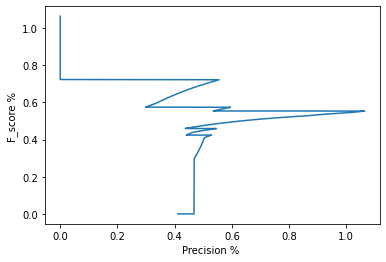

In [51]:
import matplotlib.pyplot as plt
plt.plot(x,f_score)
plt.xlabel('Precision % ')
plt.ylabel('F_score % ')
plt.show;